# Question A3

Find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Question 1 and 2

#### Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

This might take a while to run, approximately 20 - 30 min, so plan your time carefully.

1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2. To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [2]:
# YOUR CODE HERE
from common_utils import CustomDataset, loss_fn, split_dataset, preprocess_dataset, EarlyStopper

3. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [3]:
#MLP model
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),  #first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(no_hidden, 128),  #second hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 128),  #third hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, no_labels),  #output layer
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits


    
    
    

    
#implementing train loop
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        y_long = y.type(torch.LongTensor)
        loss = loss_fn(pred, y_long)

        # Backpropagation
        optimizer.zero_grad()  #initialize gradient calculations
        loss.backward()  #compute gradients
        optimizer.step()  #take one step of SGD

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct




#implementing test loop
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            y_long = y.type(torch.LongTensor)
            test_loss += loss_fn(pred, y_long).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct






def train(model, X_train_scaled, y_train2, X_val_scaled, y_val2, batch_size):
    
    
    # YOUR CODE HERE
    
    train_accuracies, train_losses, test_accuracies, test_losses, times = [],[],[],[],[]
    
    lr = 0.001
    no_epochs = 100
    
    
    #initialising dataloader
    train_data = CustomDataset(X_train_scaled, y_train2)
    test_data = CustomDataset(X_val_scaled, y_val2)

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    
    
    #initialising loss_fn
    loss_fn = torch.nn.CrossEntropyLoss()
    
    
    #initialising optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
        
    
    #initialising early stopper for each fold before we begin training
    early_stopper = EarlyStopper(min_delta = 0.00005) #min_delta = 0.00005
    early_stopper_bool = False
    
    
    #begin training
    for epoch in range(no_epochs):
        t = 0

        #start time
        start_time = time.time()

        #obtain acc and loss
        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn)
        
        t += time.time() - start_time
        
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        test_accuracies.append(test_accuracy)
        test_losses.append(test_loss)
        times.append(t)
        

        #early stopper used on val_loss
        early_stopper_bool = early_stopper.early_stop(test_loss)
        if early_stopper_bool:
            print(f"Early stopped at {epoch+1}!")  
            break

    
    
    
    
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [4]:
#using the same settings as our model in A1
no_features = 77
no_labels = 2

def find_optimal_hyperparameter(X_train, y_train, parameters, mode, batch_size):

    # YOUR CODE HERE
    
    fold = [0,1,2,3,4] #index for our 5-folds
    
    cross_validation_accuracies, cross_validation_times = [], []
    
    
    #Initialising our dictionaries for data
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = {},{},{},{}  #creating our dictionaries to return
    
    
    #fixing the kfold random_states for each neuron number
    cv = KFold(n_splits = 5, shuffle=False) 
    
    #filling up our dictionaries
    for neurons in parameters: 
        
        #initialising the values of the keys (neurons) in the dictionary as lists
        X_train_scaled_dict[neurons] = []
        X_val_scaled_dict[neurons] = []
        y_train_dict[neurons] = []
        y_val_dict[neurons] = []
        
    

        for train_idx, val_idx in cv.split(X_train, y_train):
            x_train_fold, y_train_fold  = X_train[train_idx], y_train[train_idx]
            x_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]
            
            #scaling X values using preprocess_dataset() function is common_utils
            x_train_scaled_fold, x_val_scaled_fold = preprocess_dataset(x_train_fold, x_val_fold)
    
            X_train_scaled_dict[neurons].append(x_train_scaled_fold)
            X_val_scaled_dict[neurons].append(x_val_scaled_fold)
            y_train_dict[neurons].append(y_train_fold)
            y_val_dict[neurons].append(y_val_fold)
    
    #now that our dictionary has been made, we can commence training
    
    for neurons in parameters:
        print(f"{mode}: {neurons}")
        
        
        foldTimes = [] #list to store the 5 last epoch times of 5 folds
        foldAcc = [] #list to store the 5 last epoch acc values of 5 folds
        
        #looping through folds
        for idx in fold:
            print("Fold: ", idx+1)
            
            
            model = MLP(no_features, neurons, no_labels)
            train_accuracies, train_losses, test_accuracies, test_losses, times = train(model, X_train_scaled_dict[neurons][idx], y_train_dict[neurons][idx], X_val_scaled_dict[neurons][idx], y_val_dict[neurons][idx], batch_size)
            
            
            lastEpochAcc = test_accuracies[-1]
            lastEpochTime = times[-1]
            
            #printing last epoch acc and time taken for observation
            print("Last epoch accuracy value: ", lastEpochAcc)
            print("Last epoch time taken: ", lastEpochTime)
            
            
            foldTimes.append(lastEpochTime)
            foldAcc.append(lastEpochAcc)
        
    
        
        ##printing mean last epoch acc and time taken for observation
        meanAcc = np.mean(foldAcc) #obtaining the mean acc
        print(f"\nMean CV accuracy for neuron size {neurons}: {meanAcc}\n")
        
        
        meanTime = np.mean(foldTimes) #obtaining the mean time
        print(f"Mean time taken to train network on last epoch for neuron size {neurons}: {meanTime}\n")
        print("----------------------------------------")
            
        

        cross_validation_times.append(meanTime)
        cross_validation_accuracies.append(meanAcc)

        
        
    return cross_validation_accuracies, cross_validation_times




'''
optimal_bs = 0. Fill your optimal batch size in the following code.
'''
# YOUR CODE HERE




#obtaining our X_train and y_train, and keeping X_test and y_test for later use
label_encoder = preprocessing.LabelEncoder()

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'] = label_encoder.fit_transform(df['label'])  #changing the labels from neg/pos to 1/0

y = df['label'].to_numpy()
X = df.drop(["filename","label"], axis=1)

#we will be keeping X_test and y_test for the testing later
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)



num_neurons = [64, 128, 256]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train.to_numpy(), y_train, num_neurons, 'num_neurons', 1024)

num_neurons: 64
Fold:  1
Last epoch accuracy value:  0.681872037914692
Last epoch time taken:  0.12426185607910156
Fold:  2
Last epoch accuracy value:  0.7020142180094787
Last epoch time taken:  0.11409497261047363
Fold:  3
Last epoch accuracy value:  0.6860189573459715
Last epoch time taken:  0.10391902923583984
Fold:  4
Last epoch accuracy value:  0.6812796208530806
Last epoch time taken:  0.1219947338104248
Fold:  5
Last epoch accuracy value:  0.6965026674570243
Last epoch time taken:  0.23262476921081543

Mean CV accuracy for neuron size 64: 0.6895375003160493

Mean time taken to train network on last epoch for neuron size 64: 0.13937907218933104

----------------------------------------
num_neurons: 128
Fold:  1
Last epoch accuracy value:  0.7203791469194313
Last epoch time taken:  0.09728789329528809
Fold:  2
Last epoch accuracy value:  0.7043838862559242
Last epoch time taken:  0.0960533618927002
Fold:  3
Last epoch accuracy value:  0.7014218009478673
Last epoch time taken:  0.1

4. Plot the cross-validation accuracies against the number of epochs for different numbers of hidden-layer neurons. Limit the search space of the number of neurons to {64, 128, 256}.

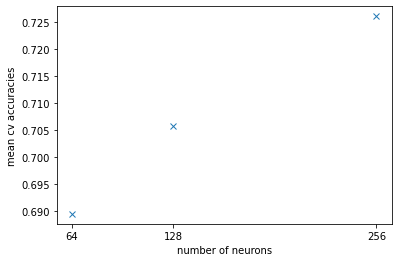

In [5]:
# I will be following what the assignment PDF wants, which is the mean cv-accuracy on the final epoch, against the different number of hiddern-layer neurons
# There seems to be a typo for the above point #4

plt.figure(1)
plt.plot(num_neurons, cross_validation_accuracies, marker = 'x', linestyle = 'None')
plt.xticks(num_neurons)
plt.xlabel('number of neurons')
plt.ylabel('mean cv accuracies')
plt.show()

5. Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

In [6]:
optimal_neurons = 256
reason = "256 neurons for the first hidden layer resulted in the highest mean cv accuracies for the last epoch."
# YOUR CODE HERE

6. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.

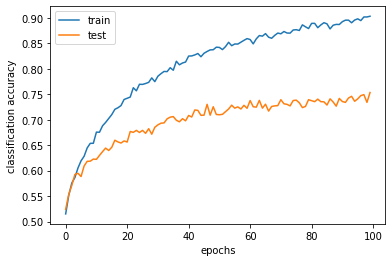

In [7]:
# YOUR CODE HERE

# #preprocessing our X_train and X_test
X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)


no_features = 77
no_labels = 2

#initialising model with optimal neurons (256)
model = MLP(no_features, optimal_neurons, no_labels)

#starting our training
train_acc_, train_loss_, test_acc_, test_loss_, times_ = train(model, X_train_scaled, y_train, X_test_scaled, y_test, 1024)


plt.figure(2)
plt.plot(range(len(train_acc_)), train_acc_, label='train')
plt.plot(range(len(test_acc_)), test_acc_, label='test')
plt.xlabel('epochs')
plt.ylabel('classification accuracy')
plt.legend()